In [107]:
# Imports
%reset -f
import json
import pandas
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta, timezone
import geopandas as gpd
import pandas as pd
import gps_time
import re
from io import StringIO

INGV Data fetch

In [108]:
DELTA_MINUTES = 30
ELEVATION_MIN = 20
INGV_BASE_URL = "http://ws-eswua.rm.ingv.it/scintillation.php/records/ws"
IMPC_BASE_URL = "https://impc.dlr.de/SWE/Ionospheric_Perturbations/Local_Scintillation_Measurements/"
END_DT = datetime.now(timezone.utc).isoformat(sep=' ', timespec='seconds') # current datetime
START_DT = (datetime.now(timezone.utc) - timedelta(minutes=DELTA_MINUTES)).isoformat(sep=' ', timespec='seconds') # current minus
LEAP_SECONDS = 18

In [109]:
def gps_to_utc(gpsweek,gpsseconds,leapseconds):
    datetimeformat = "%Y-%m-%d %H:%M:%S"
    epoch = datetime.strptime("1980-01-06 00:00:00",datetimeformat)
    elapsed = timedelta(days=(gpsweek*7),seconds=(gpsseconds-leapseconds))
    return (epoch + elapsed).replace(tzinfo=timezone.utc)

In [110]:
# GeoPandas initialization
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [111]:
# INGV Stations lists with related metadata
def init_stations_INGV():
    ingv_stations = json.loads(requests.get("http://ws-eswua.rm.ingv.it/scintillation.php/records/wsstation?order=code&include=code,lat,lon,name,status").content)["records"]
    ingv_active_stations = list()
    not_wanted_stations = ["dmc0p", "dmc1p", "dmc2p","lyb0p", "mal0p","mzs0p"]

    for station in ingv_stations:
        if station["status"] == "Active" and station["code"] not in not_wanted_stations:
            ingv_active_stations.append(station)
    return pd.DataFrame(ingv_active_stations).drop(columns=["status"])

def init_stations_IMPC():
    df = pd.DataFrame()
    df["code"] = pd.Series(["mski01", "msnz02","msto01","mste01"])
    df["lat"] = [67.8, 53.3, 43.6, 28.5]
    df["lon"] = [20.4, 13.1, 1.5, -16.3]
    df["name"] = ["Kiruna", "Neustrelitz", "Toulouse", "Tenerife"]
    return df

stations_INGV = init_stations_INGV()
stations_IMPC = init_stations_IMPC()
stations = pd.concat([stations_IMPC, stations_INGV], ignore_index=True)

In [112]:
def get_s4_ingv_lasts(id_station,):
    request_url = INGV_BASE_URL + id_station + "?filter=dt,bt," + START_DT + "," + END_DT + "&filter=elevation,gt," + str(ELEVATION_MIN) + "&order=dt,desc&include=dt,elevation,ipp_lat,ipp_lon,totals4l1,sigmaccdl1"
    response = requests.get(request_url)

    if response.status_code !=200:
        print("ERROR - " + id_station + "HTTP Response Code :" + str(response.status_code))

        return -1
    elif response.content == b'{"records":[]}':
        print("ERROR - " + id_station + " - Void Content")
        return pd.DataFrame()
    else:
        station_data_records = pd.json_normalize(json.loads(response.content)["records"])
        print("OK - " + id_station + " Fetched")
        formatted_data = pd.DataFrame()
        formatted_data["datetime"] = station_data_records["dt"]
        formatted_data["code"] = id_station
        formatted_data["name"] = stations.loc[stations["code"] == id_station]["name"].values[0]
        formatted_data["lat"] = station_data_records["ipp_lat"]
        formatted_data["lon"] = station_data_records["ipp_lon"]
        formatted_data["s4"] = station_data_records["totals4l1"]
        formatted_data["sigmaphi"] =station_data_records["sigmaccdl1"]
        return formatted_data

def get_s4_ingv_all():
    s4_data = pd.DataFrame()
    for station_code in stations_INGV["code"]:
        s4_data = pd.concat([s4_data,get_s4_ingv_lasts(station_code)], ignore_index=True)
    return pd.DataFrame(s4_data)

In [113]:
# http s://impc.dlr.de/SWE/Ionospheric_Perturbations/Local_Scintillation_Measurements/msto01/2023/001/ for free access archives (no login required)
def get_s4_impc_lasts(id_station):
    request_url = IMPC_BASE_URL + id_station + "/latest/" + id_station + "scintillation.dat"
    response = requests.get(request_url)

    if response.status_code !=200:
        print("ERROR - " + id_station + "HTTP Response Code :" + str(response.status_code))
        return -1
    else:
        # Replace spaces by a comma the, deleting first column of commas
        data = re.sub(r" +", ",", response.content.decode(), 0, re.MULTILINE)
        data = re.sub(r"^,", "", data, 0, re.MULTILINE)

        columns = ["GPS_Week", "GPS_TOW", "PRN", "S4", "Sigma"]

        # String to an IO data to be read with pandas
        dataIO = StringIO(data)
        station_data_records = pd.read_csv(dataIO, header=0, names= columns, index_col=False)
        print("OK - " + id_station + " Fetched")

        formatted_data = pd.DataFrame()
        formatted_data["datetime"] = station_data_records.apply(lambda x: gps_to_utc(x.GPS_Week,x.GPS_TOW,LEAP_SECONDS), axis=1)
        formatted_data["code"] =     id_station
        formatted_data["name"] =     stations.loc[stations["code"] == id_station]["name"].values[0]
        formatted_data["lat"] =      stations.loc[stations["code"] == id_station]["lat"].values[0]
        formatted_data["lon"] =      stations.loc[stations["code"] == id_station]["lon"].values[0]
        formatted_data["s4"] =       station_data_records["S4"]
        formatted_data["sigmaphi"] = station_data_records["Sigma"]
        return formatted_data

def get_s4_impc_all():
    s4_data = pd.DataFrame()
    for station_code in stations_IMPC["code"]:
        s4_data = pd.concat([s4_data,get_s4_impc_lasts(station_code)], ignore_index=True)
    s4_data["timestamp"] = s4_data["datetime"].apply(datetime.timestamp)
    s4_data["timestamp"] = s4_data["timestamp"].apply(str)
    s4_data.drop(s4_data[s4_data["timestamp"] < str(datetime.fromisoformat(START_DT).timestamp())].index, inplace=True)
    return s4_data

In [114]:
def get_s4_from_stations():
    return pd.concat([get_s4_impc_all(),get_s4_ingv_all()])

In [117]:
s4_data_allstations = get_s4_from_stations()

OK - mski01 Fetched
OK - msnz02 Fetched
OK - msto01 Fetched
OK - mste01 Fetched
OK - cha0p Fetched
OK - han0p Fetched
OK - hel0p Fetched
OK - kil0n Fetched
OK - klu0p Fetched
OK - lam0p Fetched
OK - nic0p Fetched
OK - nya0p Fetched
OK - nya1p Fetched
OK - sab0p Fetched
OK - san0p Fetched
OK - sao0p Fetched
OK - seu0p Fetched
OK - thu0p Fetched
OK - tuc0p Fetched
OK - ush0p Fetched


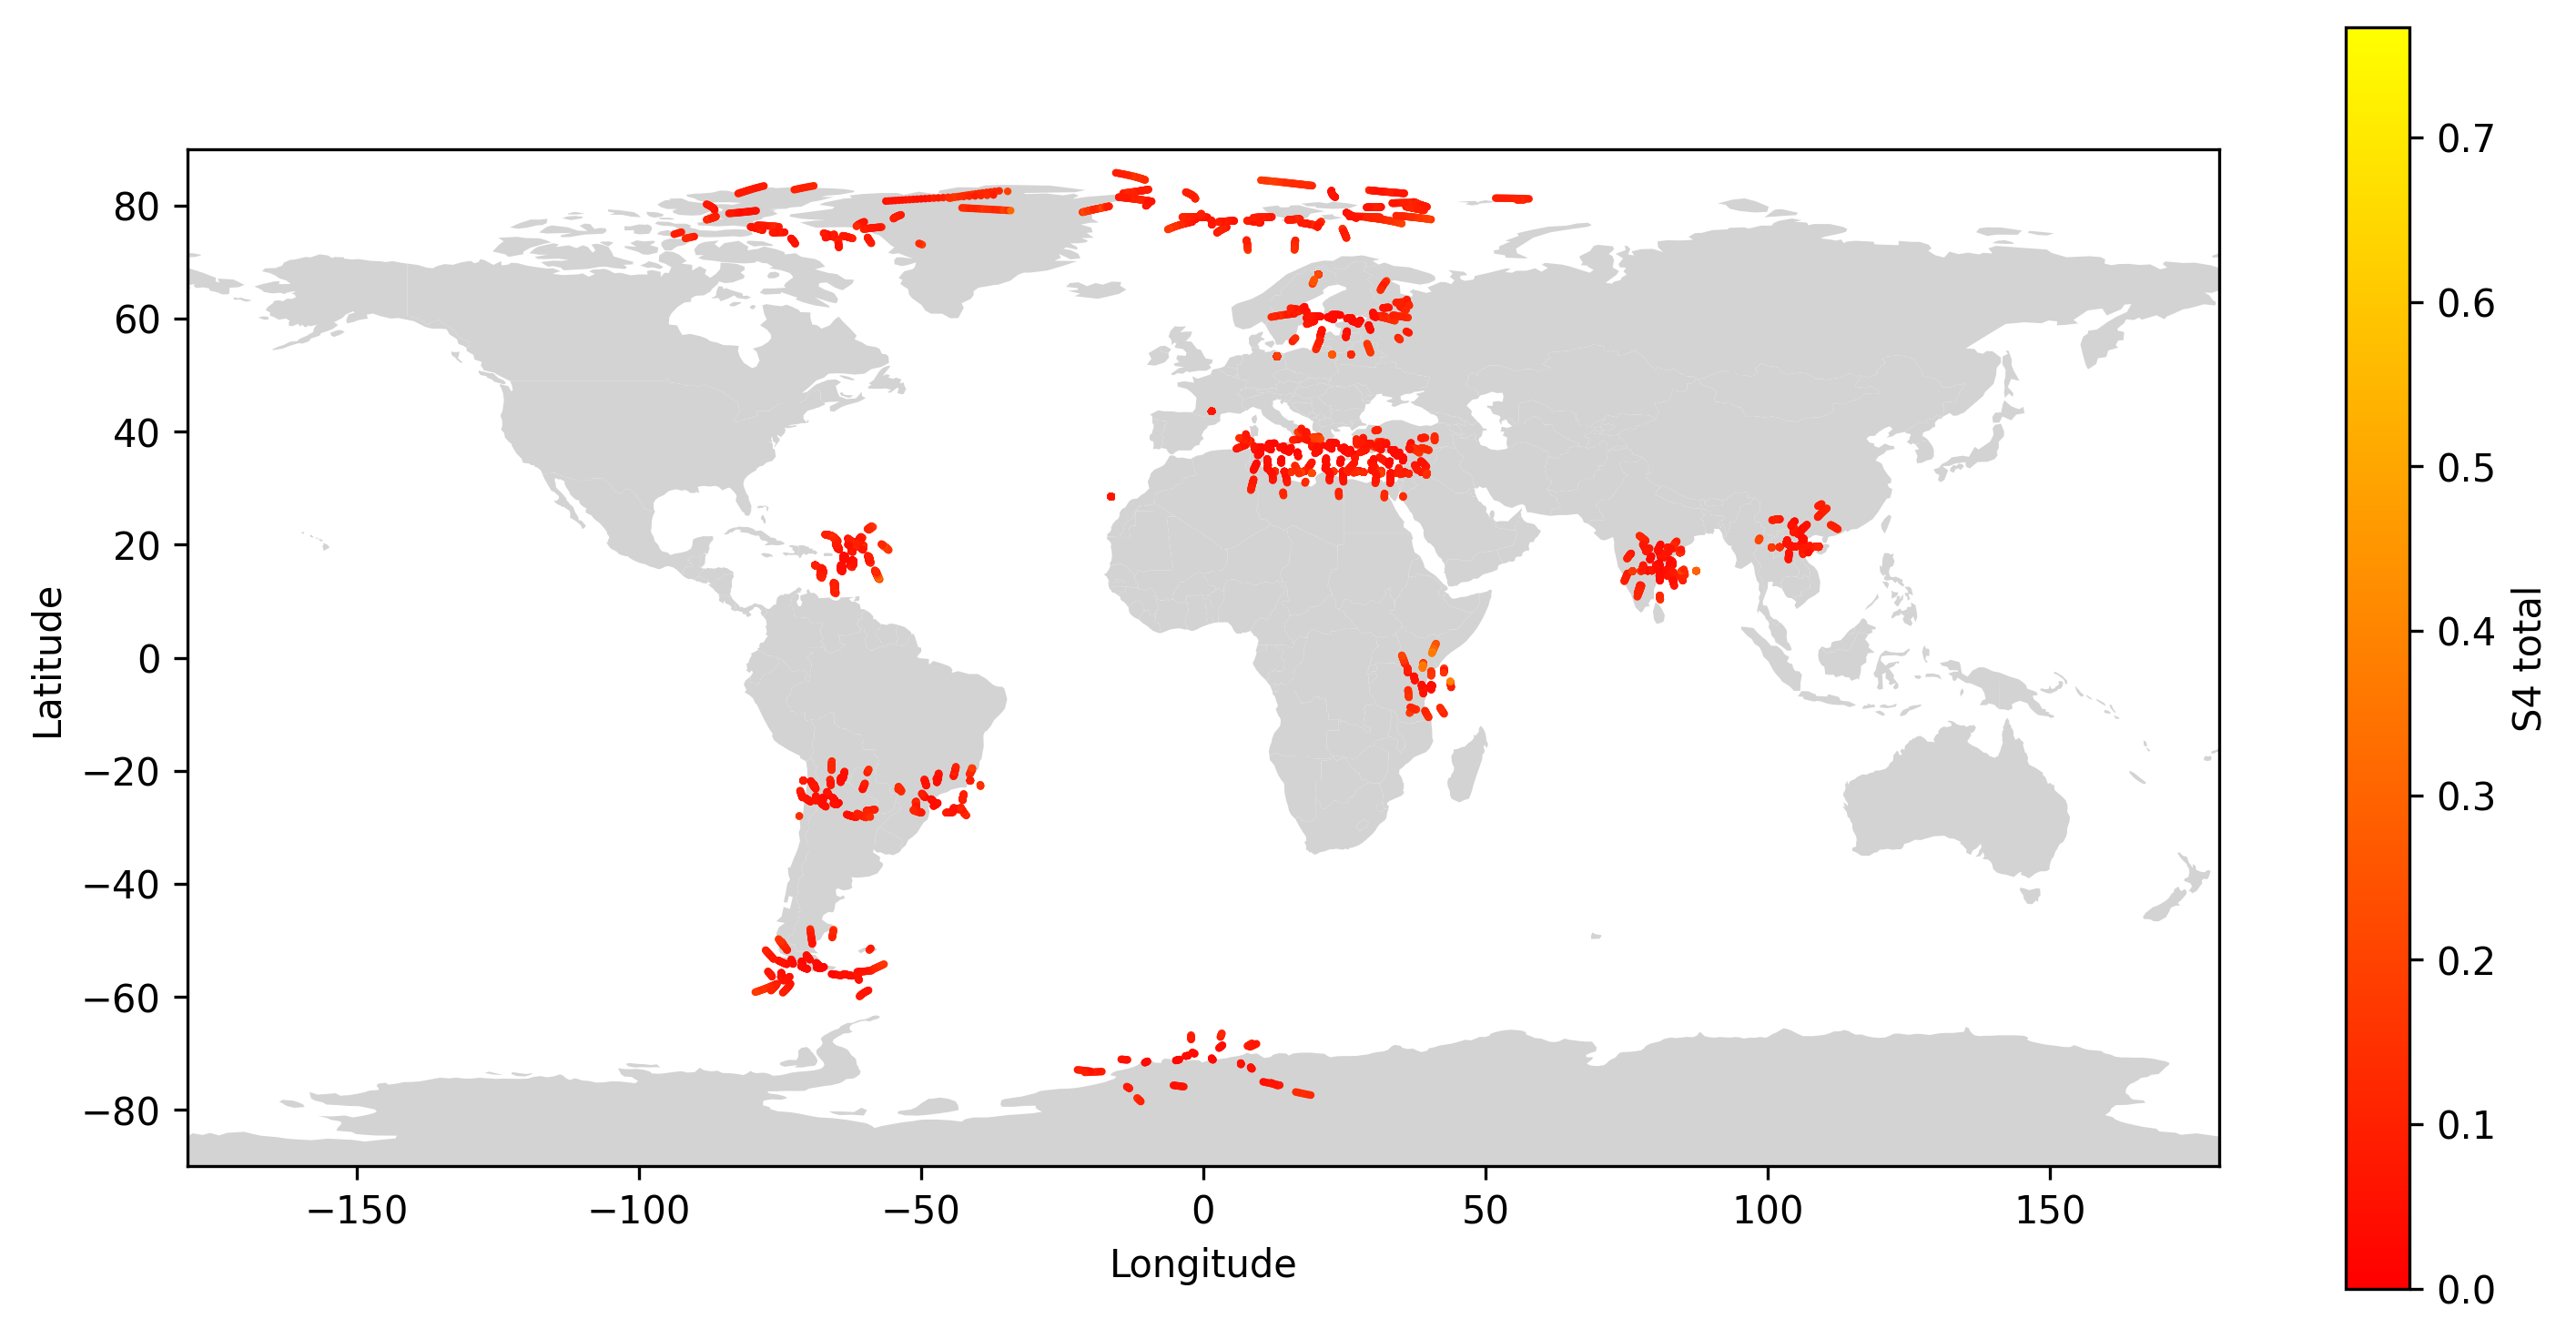

In [119]:
# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6),dpi=300)
worldmap.plot(color="lightgrey", ax=ax)
# Plotting with a color map
x = s4_data_allstations['lon']
y = s4_data_allstations['lat']
z = s4_data_allstations['s4']
plt.scatter(x, y, s=1, c=z, alpha=1, vmin=0,
            cmap='autumn')
plt.colorbar(label='S4 total')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

#first_year = df["Datetime"].min().strftime("%Y")
#last_year = df["Datetime"].max().strftime("%Y")
#plt.title("NASA: Fireballs Reported by Government Sensors\n" +
 #         str(first_year) + " - " + str(last_year))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()